<h1>Inhaltsverzeichnis<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Hilfsfunktionen-definieren" data-toc-modified-id="Hilfsfunktionen-definieren-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Hilfsfunktionen definieren</a></span></li><li><span><a href="#Experimmente:-Anzahl-an-Schichten" data-toc-modified-id="Experimmente:-Anzahl-an-Schichten-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Experimmente: Anzahl an Schichten</a></span></li></ul></div>

# Hilfsfunktionen definieren

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Activation, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D, ZeroPadding2D
from tensorflow.keras import backend as K

def baue_cnn_model(shape_of_input, nr_output_neurons, nr_layers, kernel_side_len):
    """
    Baut ein komplettes CNN auf
    """
        
    # clear the last Keras session
    # this will clear the underlying TensorFlow graph
    K.clear_session()

    model = Sequential()
    
    for layer_nr in range(0, nr_layers):    
        nr_filter       = 32        
        kernel_stride   = 1
        if layer_nr==0:
            model.add( Conv2D(nr_filter,
                              kernel_size=(kernel_side_len,kernel_side_len),
                              strides=(kernel_stride,kernel_stride),
                              activation='relu',
                              input_shape=shape_of_input) )
        else:
            model.add( Conv2D(nr_filter,
                              kernel_size=(kernel_side_len,kernel_side_len),
                              strides=(kernel_stride,kernel_stride),
                              activation='relu') )

        model.add( MaxPooling2D(pool_size=(2, 2), strides=(2, 2)) )
                 

    model.add(Flatten())
    model.add(Dense(1024, activation="relu"))
    model.add(Dense(nr_output_neurons, activation='softmax'))
    
    model.compile(optimizer='adam', loss='categorical_crossentropy')
    
    model.build()
    
    model.summary()

    return model


def trainiere_cnn(das_cnn, bildds, anz_train_schritte):
    """
    Trainiert das angegebene CNN mit dem angegebenen
    Bilddatensatz für die angegebene Anzahl von
    Trainingsschritten
    """

    from datetime import datetime
    
    time_start = datetime.now()
    
    height      = input_shape[0]
    width       = input_shape[1]
    nr_channels = input_shape[2]

    X = np.zeros( (1,height,width,nr_channels)      )
    Y = np.zeros( (1,bildds.nr_classes) )
    
    alle_fehler = []

    for train_schritt in range(0,anz_train_schritte):

        if train_schritt % 200 == 0:
            print("Trainingsschritt:", train_schritt)

        img, img_processed, class_id, class_name, teacher_vec = \
            bildds.hole_irgendein_bild()

        # Stecke das 3D Bild in das 4D Array
        # denn Keras will als Input für die
        # Trainingsmethod fit() ein 4D Array
        X[0,:,:,:] = img_processed

        # Der gewünschte Output ist dementsprechend
        # ein 2D Array
        Y[0,:] = teacher_vec


        # Trainiere das Modell mit diesem Bild
        history = das_cnn.fit(X,Y,verbose=0)
        
        fehler_img = history.history["loss"][0]
        alle_fehler.append( fehler_img )
        
    plt.plot(alle_fehler)
    plt.show()
        
    time_stop = datetime.now()
        
    print("Training zu Ende:")
    print("\tTraining-Start:  ", time_start)
    print("\tTraining-Stop:   ", time_stop)
    print("\tTrainings-Dauer: ", time_stop - time_start)
    
    
def teste_cnn(das_cnn, bildds, zeige_bsp_klassifikationen=False):
    """
    Testet das angegebene CNN mit dem angegebenen Bilddatensatz
    und zeigt evtl. Beispielklassifikationen an
    """
    
    korrekt = 0
    
    print("Ich werde das CNN auf {} Tesbildern testen".
          format(bildds.nr_images))
    
    for test_bild_nr in range(0, bildds.nr_images):
        
        if test_bild_nr % 100 == 0:
            print("{} Bilder getestet".format(test_bild_nr))
        
        # 1. hole nächstes Testbild
        img, img_processed, class_id, class_name, teacher_vec = \
            bildds.hole_bild_per_index(test_bild_nr)
    
        
        # 2. 3D Bild in 4D Array umwandeln
        X = img_processed.reshape((-1,
                                   img_processed.shape[0],
                                   img_processed.shape[1],
                                   img_processed.shape[2] ))
        
        # 3. Klassifiziere jetzt!
        neuron_outputs = das_cnn.predict(X)
        
        # 4. Bestimme prädizierte Klasse
        predicted_class_nr = np.argmax(neuron_outputs.reshape(-1))
        
        # 5. Prädiktion korrekt?
        if predicted_class_nr == class_id:
            korrekt +=1
            
        # 6.
        # Show image, predicted class and gt class?
        if zeige_bsp_klassifikationen and np.random.randint(5)==0:
            
            predicted_class_label = \
                bildds.class_names[predicted_class_nr]
                                
            plt.title("Ist: {} vs. Prädiziert: {}\nOutputneurone: {}"
                      .format(class_name,
                              predicted_class_label,
                              neuron_outputs
                             )
                     )
            plt.imshow( img )
            plt.show()
            
        
    # Berechne Korrektklassifikationsrate
    korrekt_rate = float(korrekt) / float(bildds.nr_images)
        
    print("Korrekt klassifiziert: {} of {} images:"
          " --> rate: {:.2f}"
          .format(korrekt,
                  bildds.nr_images,
                  korrekt_rate)
         )
    
    return korrekt_rate



# Experimmente: Anzahl an Schichten

Unter dem Verzeichnis
	 /home/juebrauer/link_to_vcd/07_datasets/08_bikes_vs_cars/train 
habe ich folgende Unterordner/Klassen gefunden:
['car', 'bike']
1107 Dateien im Unterverzeicnis /home/juebrauer/link_to_vcd/07_datasets/08_bikes_vs_cars/train/car/
1144 Dateien im Unterverzeicnis /home/juebrauer/link_to_vcd/07_datasets/08_bikes_vs_cars/train/bike/
Insgesamt sind 2251 Bilder verfügbar
Unter dem Verzeichnis
	 /home/juebrauer/link_to_vcd/07_datasets/08_bikes_vs_cars/test 
habe ich folgende Unterordner/Klassen gefunden:
['car', 'bike']
200 Dateien im Unterverzeicnis /home/juebrauer/link_to_vcd/07_datasets/08_bikes_vs_cars/test/car/
200 Dateien im Unterverzeicnis /home/juebrauer/link_to_vcd/07_datasets/08_bikes_vs_cars/test/bike/
Insgesamt sind 400 Bilder verfügbar


--------------------------------------------
Experiment: CNN mit 1 Schicht(en)
--------------------------------------------
Model: "sequential"
_________________________________________________________________
Layer (type)  

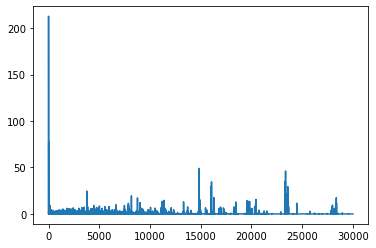

Training zu Ende:
	Training-Start:   2021-05-31 15:36:51.803071
	Training-Stop:    2021-05-31 18:56:25.766080
	Trainings-Dauer:  3:19:33.963009
Ich werde das CNN auf 400 Tesbildern testen
0 Bilder getestet
100 Bilder getestet
200 Bilder getestet
300 Bilder getestet
Korrekt klassifiziert: 336 of 400 images: --> rate: 0.84
Korrekt_klassifikations_rate : 0.84


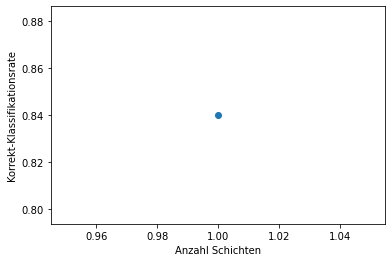



--------------------------------------------
Experiment: CNN mit 2 Schicht(en)
--------------------------------------------
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 98, 98, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 49, 49, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 47, 47, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 23, 23, 32)        0         
_________________________________________________________________
flatten (Flatten)            (None, 16928)             0         
_________________________________________________________________
dense (Dense)                (None, 1024)              1733529

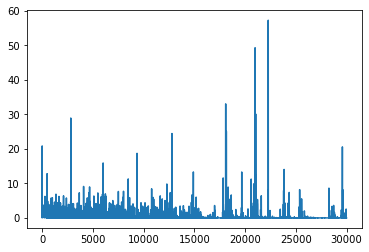

Training zu Ende:
	Training-Start:   2021-05-31 18:56:44.534766
	Training-Stop:    2021-05-31 19:52:41.231637
	Trainings-Dauer:  0:55:56.696871
Ich werde das CNN auf 400 Tesbildern testen
0 Bilder getestet
100 Bilder getestet
200 Bilder getestet
300 Bilder getestet
Korrekt klassifiziert: 344 of 400 images: --> rate: 0.86
Korrekt_klassifikations_rate : 0.86


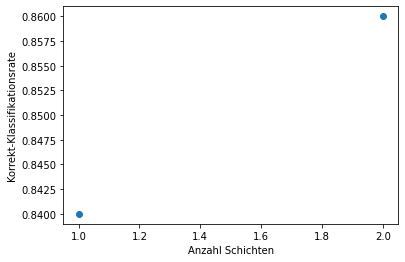



--------------------------------------------
Experiment: CNN mit 3 Schicht(en)
--------------------------------------------
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 98, 98, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 49, 49, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 47, 47, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 23, 23, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 21, 21, 32)        9248      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 10, 10, 32)        0      

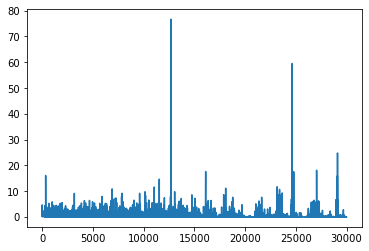

Training zu Ende:
	Training-Start:   2021-05-31 19:52:52.873778
	Training-Stop:    2021-05-31 20:14:47.693515
	Trainings-Dauer:  0:21:54.819737
Ich werde das CNN auf 400 Tesbildern testen
0 Bilder getestet
100 Bilder getestet
200 Bilder getestet
300 Bilder getestet
Korrekt klassifiziert: 340 of 400 images: --> rate: 0.85
Korrekt_klassifikations_rate : 0.85


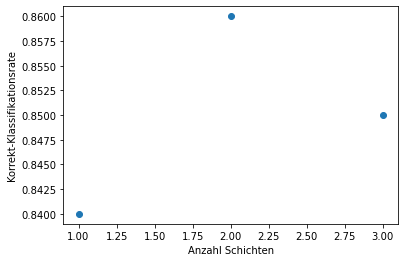



--------------------------------------------
Experiment: CNN mit 4 Schicht(en)
--------------------------------------------
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 98, 98, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 49, 49, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 47, 47, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 23, 23, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 21, 21, 32)        9248      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 10, 10, 32)        0      

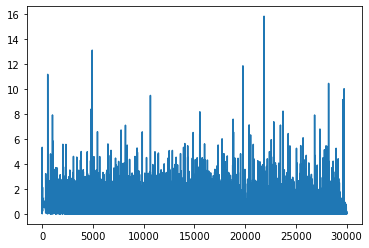

Training zu Ende:
	Training-Start:   2021-05-31 20:14:57.651125
	Training-Stop:    2021-05-31 20:31:14.135565
	Trainings-Dauer:  0:16:16.484440
Ich werde das CNN auf 400 Tesbildern testen
0 Bilder getestet
100 Bilder getestet
200 Bilder getestet
300 Bilder getestet
Korrekt klassifiziert: 349 of 400 images: --> rate: 0.87
Korrekt_klassifikations_rate : 0.8725


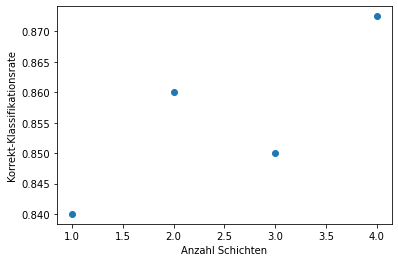



--------------------------------------------
Experiment: CNN mit 5 Schicht(en)
--------------------------------------------
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 98, 98, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 49, 49, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 47, 47, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 23, 23, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 21, 21, 32)        9248      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 10, 10, 32)        0      

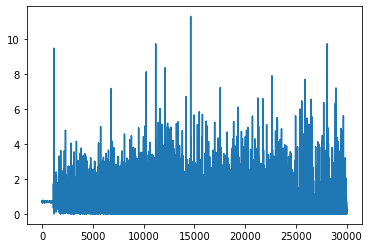

Training zu Ende:
	Training-Start:   2021-05-31 20:31:23.788583
	Training-Stop:    2021-05-31 20:46:52.636437
	Trainings-Dauer:  0:15:28.847854
Ich werde das CNN auf 400 Tesbildern testen
0 Bilder getestet
100 Bilder getestet
200 Bilder getestet
300 Bilder getestet
Korrekt klassifiziert: 361 of 400 images: --> rate: 0.90
Korrekt_klassifikations_rate : 0.9025


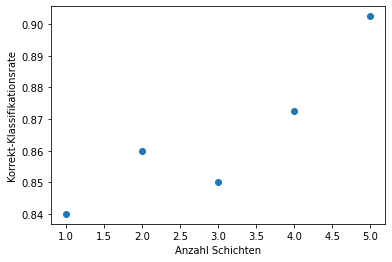

In [2]:
# Vorbereiten der Trainings- und Testdaten
from bilddatensatz import bilddatensatz
img_size_heute = (100,100)
input_shape = (img_size_heute[0], img_size_heute[1], 3)

train_folder = r"/home/juebrauer/link_to_vcd/07_datasets/08_bikes_vs_cars/train"
bd_train = bilddatensatz( train_folder, img_size_heute )

test_folder = r"/home/juebrauer/link_to_vcd/07_datasets/08_bikes_vs_cars/test"
bd_test = bilddatensatz( test_folder, img_size_heute )




x = []
y = []
kernel_side_len = 3
for nr_layers in range(1,6):
    
    
        
    print("\n")
    print("--------------------------------------------")
    print(f"Experiment: CNN mit {nr_layers} Schicht(en)")
    print("--------------------------------------------")
    
    # 1. CNN Modell bauen
    mein_cnn = baue_cnn_model(input_shape, bd_train.nr_classes, nr_layers, kernel_side_len)

    # 2. CNN trainieren
    NR_TRAIN_STEPS = 30000    
    trainiere_cnn(mein_cnn, bd_train, NR_TRAIN_STEPS)

    # 3. CNN testen
    korrekt_klassifikations_rate = teste_cnn(mein_cnn, bd_test)
    print("Korrekt_klassifikations_rate :",korrekt_klassifikations_rate)
    
    # 4. Speichere Ergebnisse
    x.append( nr_layers )
    y.append( korrekt_klassifikations_rate )
    
    # 5. Plotte Ergebnisse so weit
    plt.scatter(x,y)
    plt.xlabel("Anzahl Schichten")
    plt.ylabel("Korrekt-Klassifikationsrate")
    plt.show()    